Data Loading and Exploratory Data Analysis

In [28]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Configure visualization settings
%matplotlib inline
sns.set_theme(style="whitegrid")

# Load the Amazon Product Reviews dataset
data = pd.read_csv("../data/raw/Reviews.csv")

# Display the first five rows
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


Inspect Dataset Structure

In [29]:
# Get dataset dimensions
print(f"Dataset contains {data.shape[0]} rows and {data.shape[1]} columns.\n")

# Get data types and non-null counts
data.info()

Dataset contains 568454 rows and 10 columns.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568428 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


Analyze Missing Values

In [30]:
# Check for number of missing values in each feature
missing_values = data.isnull().sum()
print("Missing Values Per Feature:")
print(missing_values)

Missing Values Per Feature:
Id                         0
ProductId                  0
UserId                     0
ProfileName               26
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Time                       0
Summary                   27
Text                       0
dtype: int64


Explore Target Variable Distribution

Score Distribution:
Score
1     52268
2     29769
3     42640
4     80655
5    363122
Name: count, dtype: int64


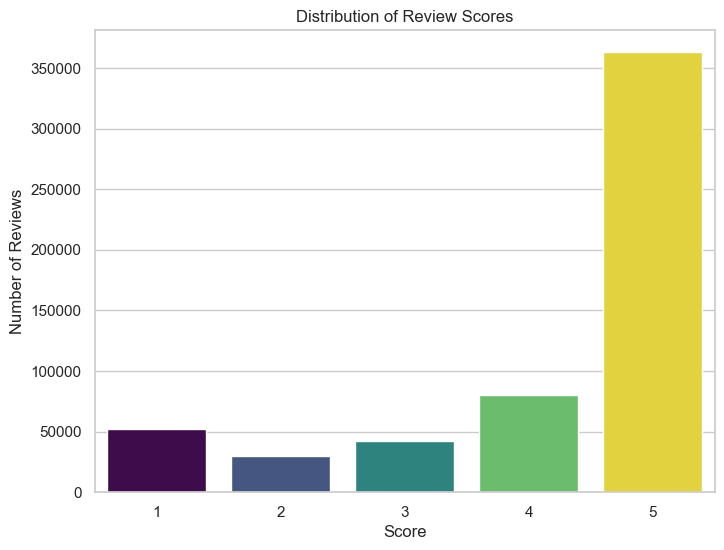

In [31]:
# Check class distribution for the target variable 'Score'
score_counts = data['Score'].value_counts().sort_index()
print("Score Distribution:")
print(score_counts)

# Visualization of Score Distribution
plt.figure(figsize=(8,6))
sns.countplot(x='Score', data=data, hue='Score', palette='viridis', legend=False)
plt.title('Distribution of Review Scores')
plt.xlabel('Score')
plt.ylabel('Number of Reviews')
plt.show()

Data Preprocessing - Handling Missing Values and Dropping Unnecessary Features

In [32]:
# Drop features unnecessary for sentiment analysis
data.drop(columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Time'], inplace=True)
# Verify remaining columns
data.head()

,Score,Summary,Text
0,5,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,4,"""Delight"" says it all",This is a confection that has been around a fe...
3,2,Cough Medicine,If you are looking for the secret ingredient i...
4,5,Great taffy,Great taffy at a great price. There was a wid...


Handling Missing Values In The 'Summary' Feature

In [33]:
# Fill missing 'Summary' values with an empty string
data.fillna({'Summary': ''}, inplace=True)

missing_values = data.isnull().sum()
print("Missing Values Per Feature:")
print(missing_values)

Missing Values Per Feature:
Score      0
Summary    0
Text       0
dtype: int64


Combine Features Important For Training

In [34]:
# Combine 'Summary' and 'Text' into a single 'Combined_Text' feature
data['Combined_Text'] = data['Summary'] + ' ' + data['Text']

# Remove leading/trailing whitespace
data['Combined_Text'] = data['Combined_Text'].str.strip()

# Verify the combination
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   Score          568454 non-null  int64 
 1   Summary        568454 non-null  object
 2   Text           568454 non-null  object
 3   Combined_Text  568454 non-null  object
dtypes: int64(1), object(3)
memory usage: 17.3+ MB


Transform Target Variable 'Score' into Categorical 'Sentiment'

In [35]:
# Map 'Score' to 'Sentiment'
def score_to_sentiment(score):
    if score in [4, 5]:
        return 'Positive'
    elif score in [1, 2]:
        return 'Negative'
    else:
        return 'Neutral'

data['Sentiment'] = data['Score'].apply(score_to_sentiment)

# Exclude 'Neutral' reviews
data = data[data['Sentiment'] != 'Neutral'].reset_index(drop=True)

# Verify feature mapping
print("Sentiment Distribution:")
print(data['Sentiment'].value_counts())

Sentiment Distribution:
Sentiment
Positive    443777
Negative     82037
Name: count, dtype: int64


Resampling To Address Class Imbalance - Now with the 'Sentiment' feature's possible values properly mapped to binary classes, it is even more clear that there is a major class imbalance that needs to be addressed.

Before Remsampling, Data Is Split Into Training, Validation, and Test sets To Prevent Information Leakage Between Sets

In [36]:
# Separate features and labels
x = data['Combined_Text']
y = data['Sentiment'].apply(lambda x: 1 if x == 'Positive' else 0)

# Before resampling, split into training, validation, and test sets
from sklearn.model_selection import train_test_split

# Split dataset into training and temporary sets (80% train, 20% temp)
X_train, X_temp, y_train, y_temp = train_test_split(
    x, y, test_size=0.2, stratify=y, random_state=42
)

# Split the temporary set into validation and test sets (10% validation, 10% test)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
)

# Ensure there are no missing values after splits
missing_values_X_train = X_train.isnull().sum()
missing_values_X_val = X_val.isnull().sum()
missing_values_X_test = X_test.isnull().sum()

print(f"Number of missing values in X_train: {missing_values_X_train}")
print(f"Number of missing values in X_val: {missing_values_X_val}")
print(f"Number of missing values in X_test: {missing_values_X_test}\n")

# Check class distributions of dataset splits
print(f"Training Set Class Distribution:\n{y_train.value_counts()}\n")
print(f"Validation Set Class Distribution:\n{y_val.value_counts()}\n")
print(f"Test Set Class Distribution:\n{y_test.value_counts()}")

Number of missing values in X_train: 0
Number of missing values in X_val: 0
Number of missing values in X_test: 0

Training Set Class Distribution:
Sentiment
1    355021
0     65630
Name: count, dtype: int64

Validation Set Class Distribution:
Sentiment
1    44378
0     8203
Name: count, dtype: int64

Test Set Class Distribution:
Sentiment
1    44378
0     8204
Name: count, dtype: int64


Applying Resampling to Training Data

In [37]:
from imblearn.over_sampling import RandomOverSampler

# Initializing the oversampler
oversampler = RandomOverSampler(random_state=42)

# Resampling the training data
X_train_resampled, y_train_resampled = oversampler.fit_resample(
    X_train.to_frame(), y_train
)

# Convert back to Series
X_train_resampled = X_train_resampled['Combined_Text']

# Verify the new class distribution
print("Resampled Training Set Class Distribution:")
print(y_train_resampled.value_counts())

# Check for missing values
print("\nNumber of Missing Values for X_train_resampled:", X_train_resampled.isnull().sum())
print("Number of Missing Values for y_train_resampled:", y_train_resampled.isnull().sum())

Resampled Training Set Class Distribution:
Sentiment
0    355021
1    355021
Name: count, dtype: int64

Number of Missing Values for X_train_resampled: 0
Number of Missing Values for y_train_resampled: 0


In [41]:
print("Data type of elements in X_train_resampled:", X_train_resampled.apply(type).unique())
X_train_resampled.info()

Data type of elements in X_train_resampled: [<class 'str'>]
<class 'pandas.core.series.Series'>
RangeIndex: 710042 entries, 0 to 710041
Series name: Combined_Text
Non-Null Count   Dtype 
--------------   ----- 
710042 non-null  object
dtypes: object(1)
memory usage: 5.4+ MB


Applying Text Cleaning

In [42]:
from src.data_preprocessing import clean_text
import nltk

# Ensure NLTK resources are downloaded
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Convert all entries to strings
X_train_resampled = X_train_resampled.astype(str)
X_val = X_val.astype(str)
X_test = X_test.astype(str)


# Apply text cleaning to the resampled training data
X_train_cleaned = X_train_resampled.apply(clean_text)
# Apply text cleaning to the validation data
X_val_cleaned = X_val.apply(clean_text)
# Apply text cleaning to the test data
X_test_cleaned = X_test.apply(clean_text)

print("Training and Test datasets successfully cleaned.")

Training and Test datasets successfully cleaned.


Saving Cleaned Data

In [43]:
# Save cleaned and resampled training data
train_data = pd.DataFrame({
    'Combined_Text': X_train_cleaned,
    'Sentiment': y_train_resampled
})
train_data.to_csv('../data/processed/cleaned_train_data.csv', index=False)

# Save Cleaned validation data
val_data = pd.DataFrame({
    'Combined_Text': X_val_cleaned,
    'Sentiment': y_val
})
val_data.to_csv('../data/processed/cleaned_val_data.csv', index=False)

# Save Cleaned test data
test_data = pd.DataFrame({
    'Combined_Text': X_test_cleaned,
    'Sentiment': y_test
})
test_data.to_csv('../data/processed/cleaned_test_data.csv', index=False)

print("Cleaned and resampled data saved.")

Cleaned and resampled data saved.
